In [1]:
# Todo
import numpy as np
from matplotlib import pyplot as plt
import torchvision
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Use GPU if you have one
print(device)

cpu


### Image segmentation using a UNET


Today, we will take a look at a UNET segmentation model. We will try this out on the Oxford  IIIT Pet dataset. This dataset is quite large (~800 MB) so I recommend downloading before class. 

NB: This notebook needs a GPU to run in a reasonable time. If you don't have one, I recommend using colab.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256))
])

def process_labels(label):
    

    new_label = torch.zeros_like(label)
    new_label[label < label.min()+0.001] = 1
    new_label[label > label.max()-0.001] = 0.5

    return new_label

target_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
    process_labels,
])


data = torchvision.datasets.OxfordIIITPet('./data/',download=True, split="trainval", target_types="segmentation",transform=transform, target_transform=target_transform)
test_data = torchvision.datasets.OxfordIIITPet('./data/',download=True, split="test", target_types="segmentation",transform=transform, target_transform=target_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


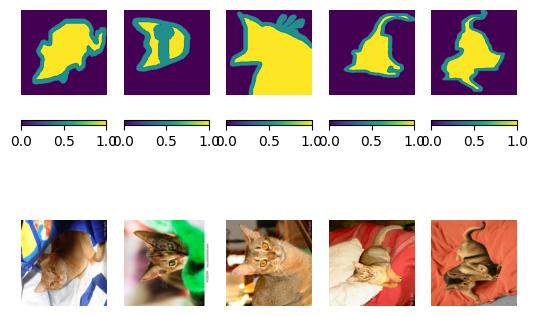

In [3]:
# Let's looks at a couple samples from the data - always look at your data

for j,batch in enumerate(data):
    plt.subplot(2,5,j+1)
    plt.imshow(batch[1].transpose(0,2)) #to tensor normalises images by default, but these are labels, so rescaling may be needed
    plt.axis('off')
    plt.colorbar(orientation='horizontal')
    plt.subplot(2,5,j+6)
    plt.imshow(batch[0].transpose(0,2))
    plt.axis('off')
    
    if j > 3:
        break
plt.show()

Looks like the data is labelled using a trimap - 3 classes, background, foreground and unknown. Let's get a pre-existing U-NET model to use.

Uh oh. I couldn't find one already trained for this type of problem. What can we do? 

Let's try to fine-tune a model trained for something else instead!

In [4]:
# !pip install pretrained-backbones-unet
import backbones_unet
from backbones_unet.model.unet import Unet

print(backbones_unet.__available_models__)


['convnext_atto', 'convnext_atto_ols', 'convnext_base', 'convnext_base_384_in22ft1k', 'convnext_base_in22ft1k', 'convnext_base_in22k', 'convnext_femto', 'convnext_femto_ols', 'convnext_large', 'convnext_large_384_in22ft1k', 'convnext_large_in22ft1k', 'convnext_large_in22k', 'convnext_nano', 'convnext_nano_ols', 'convnext_pico', 'convnext_pico_ols', 'convnext_small', 'convnext_small_384_in22ft1k', 'convnext_small_in22ft1k', 'convnext_small_in22k', 'convnext_tiny', 'convnext_tiny_384_in22ft1k', 'convnext_tiny_hnf', 'convnext_tiny_in22ft1k', 'convnext_tiny_in22k', 'convnext_xlarge_384_in22ft1k', 'convnext_xlarge_in22ft1k', 'convnext_xlarge_in22k', 'cs3darknet_focus_l', 'cs3darknet_focus_m', 'cs3darknet_l', 'cs3darknet_m', 'cs3darknet_x', 'cs3edgenet_x', 'cs3se_edgenet_x', 'cs3sedarknet_l', 'cs3sedarknet_x', 'cspdarknet53', 'cspresnet50', 'cspresnext50', 'darknet53', 'darknetaa53', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'densenetblur121d', 'dm_nfnet_f0', 'dm_nfnet_f1',

I don't know who [mberkay0](https://github.com/mberkay0/pretrained-backbones-unet) is, but I think it's pretty cool they released these model weights online! let's check out their model. It's likely you don't have a great GPU on hand so lets choose the atto model - that sounds small. This repository provides a number of Unet architectures with encoders (not the entire network) pre-trained on the Imagenet1k dataset. Imagenet1k (ILSVRC 2012) is an object recognition dataset with 1000 object classes, and 1.2M training images.

We are going to use this as the *backbone* of our unet. The core idea is the following, a model trained to do object recognition will have learned a lot about images, and it will be easier to get the model to do segmentation, than it would to train a model to do this from scratch.

In [5]:

model = Unet(
    backbone='convnext_atto', # backbone network name
    in_channels=3,            # input channels (1 for gray-scale images, 3 for RGB, etc.)
    num_classes=1,            # output channels (number of classes in your dataset)
    pretrained=True,
    preprocessing=True,
)

In [6]:
model.to(device)

Unet(
  (encoder): FeatureListNet(
    (stem_0): Conv2d(3, 40, kernel_size=(4, 4), stride=(4, 4))
    (stem_1): LayerNorm2d((40,), eps=1e-06, elementwise_affine=True)
    (stages_0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(40, 40, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=40)
          (norm): LayerNorm2d((40,), eps=1e-06, elementwise_affine=True)
          (mlp): ConvMlp(
            (fc1): Conv2d(40, 160, kernel_size=(1, 1), stride=(1, 1))
            (norm): Identity()
            (act): GELU()
            (drop): Dropout(p=0.0, inplace=False)
            (fc2): Conv2d(160, 40, kernel_size=(1, 1), stride=(1, 1))
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(40, 40, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=40)
          (norm): LayerNorm2d((40,), eps=1e-06, elementwise_affine=True)
          (mlp):

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Wow, this 'atto' model has %d parameters!"%count_parameters(model))

Wow, this 'atto' model has 5774345 parameters!


## Activity 1:

Looks like a standard u-net, but there is a problem here. Can you spot it? what is the output layer set up to do here? 
* Fill in the process labels function above to adjust the dataloader to preprocess the label images to work with this architecture.

Hint. How many classes are there in our dataset, and what are the output dimensions this model produces? What is the activation function at the end of the model? 
What values do the labels take on? If we wanted to train this model with a binary cross entropy loss, what would we need to do?

## Fine-tuning a neural network
Let's blindly apply this model to an image. Obviously this doesn't work, remember, only the encoder of the unet is trained so far.

Note that torch likes images to be channels first torch.Size([3, 256, 256]) so we will need to do some transposing to display.


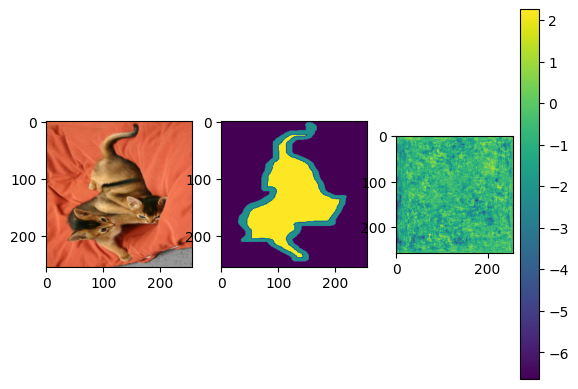

In [8]:
im = batch[0]
print("Note that torch likes images to be channels first",im.shape,"so we will need to do some transposing to display.") 
plt.subplot(1,3,1)
plt.imshow(batch[0].transpose(2,0))
plt.subplot(1,3,2)
plt.imshow(batch[1].transpose(2,0))
plt.subplot(1,3,3)
plt.imshow(model(im[np.newaxis,:,:,:].to(device)).detach().cpu().squeeze().numpy().T)
plt.colorbar()
plt.show()

But, it probably has learned a lot about generally applicable image features. Let's *fine tune* it to work in this context. To do this, we're just going to carry on training on the Oxford Pet dataset.

In [9]:
params = [p for p in model.parameters() if p.requires_grad]
optimiser = torch.optim.AdamW(params,lr=1e-4) #Set up an optimiser

train_loader = DataLoader(data,batch_size=64,shuffle=True) 
test_loader = DataLoader(data,batch_size=8,shuffle=True) 
model.train()

loss_fn = torch.nn.BCEWithLogitsLoss() # We'll use a pixel-wise Binary classification loss

epochs = 2

In [10]:

for j in range(epochs):
    
    batch_losses = []
    for batch in train_loader:
        ims,labels = batch
        
        output_pred = model(ims.to(device))
        
        loss = loss_fn(output_pred,labels.to(device))
        
        optimiser.zero_grad() # Cancel out gradients from previous optimiser steps
        loss.backward() # Compute gradient of output with respect to loss
        
        optimiser.step() # nudge the model paramters in a sensible direction to reduce the loss
        
        batch_losses.append(loss.item())
        
    print("Loss at epoch %d: %f"%(j,np.mean(batch_losses)))
    # Lets see how it does on a few samples from our test set after each epoch
    batch  = next(iter(test_loader))
    pred = model(batch[0].to(device)).detach().cpu().squeeze()
            
    for i in range(8):
            # How does it do now?
            plt.subplot(3,8,1+i)
            plt.imshow(batch[0][i,:,:,:].transpose(2,0))
            plt.axis('off')
            plt.subplot(3,8,9+i)
            plt.imshow(batch[1][i,:,:,:].transpose(2,0),vmin=0,vmax=1)
            plt.axis('off')
            plt.colorbar(orientation='horizontal')
            plt.subplot(3,8,17+i)
            plt.imshow(pred[i,:,:].T,vmin=0,vmax=1)
            plt.axis('off')
            plt.colorbar(orientation='horizontal')
    plt.subplots_adjust(hspace=0,wspace=0.2)
    plt.show()


KeyboardInterrupt: 

### Activity 2

Cool, that seems to have worked quite well. Now lets compare against training from scratch. 
* Go back and adjust the pre-trained parameter in the model definition to false, and try this again. 
* Take a note of the loss values to compare, along with the qualitative results.
* How does it do? 

Fine tuning is great, we start from a sensible initialisation and carry on training - usually we can get away with less training data this way. If you have enough data and compute though, it may be better to train from scratch though.